# DenseNet Inference (Old & New Data)

---

This is an inference Kernel. To see how I got the model, please go to the [Training Kernel here](https://www.kaggle.com/raimonds1993/aptos19-densenet-trained-with-old-and-new-data). 

If this helped you, <span style="color:red"> please upvote </span>.

As a recap, I trained a Denset on both old (2015) and new (2019) competition dataset. Considering the size of the overall dataset, I decided to split it in buckets and train the model iteratively.

UPDATE:
As you see the LB score is decreasing version by version. It was discussed in many topics and kernels that we should not trust this public test set. You can notice from the training kernel that Holdout Kappa score is actually increasing.

So, here some questions I ask myself:

- **Should we trust our validation score?**
- **Is 10% Holdout enough?**
- **Should we implement KFold CV?**

I'd love to hear what you think :)


In [1]:
import json
import math
import os
from tqdm import tqdm

import cv2
from PIL import Image

import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt

from keras import layers
from keras.applications import DenseNet121
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score

print(os.listdir('../input'))

im_size = 320

Using TensorFlow backend.


['aptos2019traineddenset', 'aptos2019-blindness-detection', 'densenet-keras']


In [2]:
test_df = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')

print(test_df.shape)

(1928, 1)


# Processing Test Images

---

Notice that here we can only see the public dataset. Once we submit our results, the kernel will rerun on the overall test set (public + private) that is around 20 GB. That needs to be considered otherwise our kernel may not work.

In [3]:
# Crop function: https://www.kaggle.com/ratthachat/aptos-updated-preprocessing-ben-s-cropping
def crop_image1(img,tol=7):
    # img is image data
    # tol  is tolerance
        
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img

def preprocess_image(image_path, desired_size=224):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = crop_image_from_gray(img)
    img = cv2.resize(img, (desired_size,desired_size))
    img = cv2.addWeighted(img,4,cv2.GaussianBlur(img, (0,0), desired_size/30) ,-4 ,128)
    
    return img

N = test_df.shape[0]
x_test = np.empty((N, im_size, im_size, 3), dtype=np.uint8)

try:
    for i, image_id in enumerate(test_df['id_code']):
        x_test[i, :, :, :] = preprocess_image(
            f'../input/aptos2019-blindness-detection/test_images/{image_id}.png',
            desired_size=im_size
        )
    print('Test dataset correctly processed')
except:
    print('Test dataset NOT processed')

Test dataset correctly processed


# Model - DenseNet 121

--- 

Here we need to replicate the architecture we used during the training phase. The difference is that we are going to load the weights we have previously found.

In [4]:
densenet = DenseNet121(
    weights='../input/densenet-keras/DenseNet-BC-121-32-no-top.h5',
    include_top=False,
    input_shape=(im_size,im_size,3)
    )


def build_model():
    model = Sequential()
    model.add(densenet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation='sigmoid'))
    return model

model = build_model()

model.load_weights('../input/aptos2019traineddenset/model.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 10, 10, 1024)      7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 5125      
Total params: 7,042,629
Trainable params: 6,958,981
Non-trainable params: 83,648
_________________________________________________________________


# Submission

---


In [5]:
y_test = model.predict(x_test) > 0.5
y_test = y_test.astype(int).sum(axis=1) - 1

test_df['diagnosis'] = y_test
test_df.to_csv('submission.csv',index=False)
print(test_df.head())

        id_code  diagnosis
0  0005cfc8afb6          2
1  003f0afdcd15          3
2  006efc72b638          3
3  00836aaacf06          2
4  009245722fa4          2


Prediction distribution:
2    47.043568
3    26.556017
0    15.663900
1     6.846473
4     3.890041
Name: diagnosis, dtype: float64


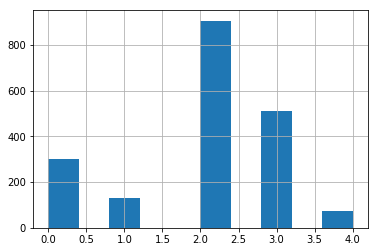

In [6]:
dist = (test_df.diagnosis.value_counts()/len(test_df))*100
print('Prediction distribution:')
print(dist)
test_df.diagnosis.hist()
plt.show()